In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('raw_data.csv', sep=',') #column names were updated during EDA to account for 'Variance' features
features = df.iloc[:,1:]

# Discretize Target Variable into Decades & Half-Decades

First, classification models to predict the decade or 5 year period a song was released will be developed - regression will later be tried to predict continuous years

Text(0.5,1,'Frequency Distribution by Decade')

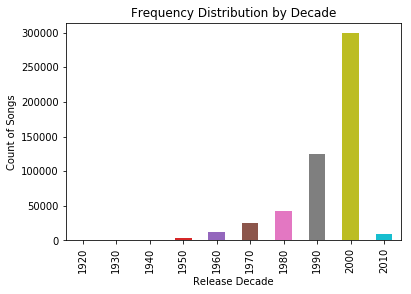

In [3]:
# Group release years into decades and half decades
decades = df['Year released'].apply(lambda year: year-(year%10)).rename('Decade released')
half_decade = df['Year released'].apply(lambda year: year-(year%5)).rename('Half decade released')
year_released = df['Year released']

df = pd.concat([year_released, half_decade, decades, features], axis=1) #include various forms of target variable in one df

#plot the distribution of observations by decade
decades.value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Release Decade")
plt.ylabel("Count of Songs")
plt.title("Frequency Distribution by Decade")

Text(0.5,1,'Frequency Distribution (bin=5yrs)')

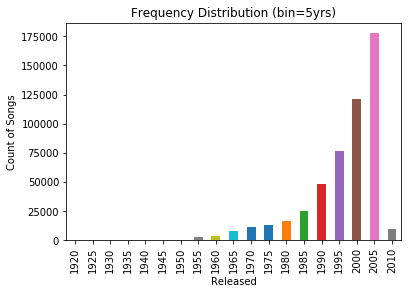

In [4]:
#plot the distribution of observations by half decade
half_decade.value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Released")
plt.ylabel("Count of Songs")
plt.title("Frequency Distribution (bin=5yrs)")

### Train / Test Split

This split, recommended by UC Irvine Machine Learning Repository, avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In [5]:
train = df[0:463715]
print('Length of training data: ' + str(len(train)))
test = df[463715:]
print('Length of test data: ' + str(len(test)))

Length of training data: 463715
Length of test data: 51630


# Trim Data

Years with too little data were removed from the dataset - in the next step, downsampling will utilize only the years with a sufficient amount of data. Removed data from before 1970 and after 2010 for now - the years in between contain the bulk of the data

In [6]:
train_trimmed = train[train['Decade released']>=1970] #filter out songs released before 1970
train_trimmed = train_trimmed[train_trimmed['Decade released']<2010] #filter out songs released after 2010

test_trimmed = test[test['Decade released']>=1970] #filter out songs released before 1970
test_trimmed = test_trimmed[test_trimmed['Decade released']<2010] #filter out songs released after 2010

In [7]:
print(train_trimmed.groupby('Decade released').size())
print('There are 22349 observations from the 1970s.')
print('Downsample other decades to this number of observations')
print('\n')

print(train_trimmed.groupby('Half decade released').size())
print('There are 10376 observations from the 1970 - 1975.')
print('Downsample other half decades to this number of observations')

Decade released
1970     22349
1980     37613
1990    112133
2000    269118
dtype: int64
There are 22349 observations from the 1970s.
Downsample other decades to this number of observations


Half decade released
1970     10376
1975     11973
1980     15002
1985     22611
1990     43416
1995     68717
2000    109314
2005    159804
dtype: int64
There are 10376 observations from the 1970 - 1975.
Downsample other half decades to this number of observations


# Downsample Training Data to Balance Classes

Class imbalances are usually detrimental to classification models, so the data from majority decades and half decades will be downsampled for classification. NOTE: from this point on there will be 2 versions of the training dataframe - one with classes downsampled by decade (~20000 per class), and one with classes downsampled by half decade (~10000 per class)
<br>
<br>
Only the training data is downsampled to balance classes, so models don't learn from biased data - the model should be able to generalize well to unbalanced test data

Text(0.5,1,'Trimmed & Downsampled Decade Data')

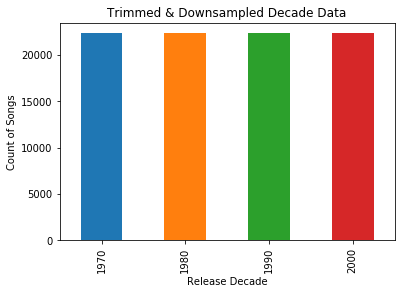

In [8]:
rows1970 = train_trimmed.loc[train_trimmed['Decade released'] == 1970]
rows1980 = train_trimmed.loc[train_trimmed['Decade released'] == 1980].sample(len(rows1970))
rows1990 = train_trimmed.loc[train_trimmed['Decade released'] == 1990].sample(len(rows1970))
rows2000 = train_trimmed.loc[train_trimmed['Decade released'] == 2000].sample(len(rows1970))
train_sampled10 = pd.concat([rows1970,rows1980,rows1990,rows2000],axis=0)
train_sampled10 = train_sampled10.sample(frac=1).reset_index(drop=True) #shuffle rows to randomize


train_sampled10['Decade released'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Release Decade")
plt.ylabel("Count of Songs")
plt.title("Trimmed & Downsampled Decade Data")

Text(0.5,1,'Trimmed & Downsampled Half Decade Data')

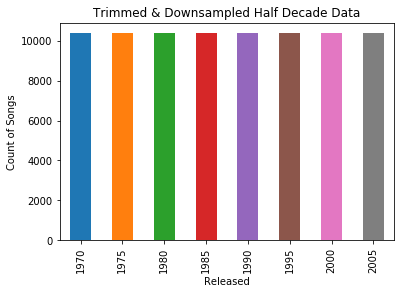

In [9]:
rows1970 = train_trimmed.loc[train_trimmed['Half decade released'] == 1970]
rows1975 = train_trimmed.loc[train_trimmed['Half decade released'] == 1975].sample(len(rows1970))
rows1980 = train_trimmed.loc[train_trimmed['Half decade released'] == 1980].sample(len(rows1970))
rows1985 = train_trimmed.loc[train_trimmed['Half decade released'] == 1985].sample(len(rows1970))
rows1990 = train_trimmed.loc[train_trimmed['Half decade released'] == 1990].sample(len(rows1970))
rows1995 = train_trimmed.loc[train_trimmed['Half decade released'] == 1995].sample(len(rows1970))
rows2000 = train_trimmed.loc[train_trimmed['Half decade released'] == 2000].sample(len(rows1970))
rows2005 = train_trimmed.loc[train_trimmed['Half decade released'] == 2005].sample(len(rows1970))
train_sampled5 = pd.concat([rows1970,rows1975,rows1980,rows1985,rows1990,rows1995,rows2000,rows2005],axis=0)
train_sampled5 = train_sampled5.sample(frac=1).reset_index(drop=True) #shuffle rows to randomize

train_sampled5['Half decade released'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Released")
plt.ylabel("Count of Songs")
plt.title("Trimmed & Downsampled Half Decade Data")

## Z-score Normalization 

In [10]:
#normalize data separately for training and test data, and for different samples
z_scores5 = train_sampled5.iloc[:,3:].apply(zscore)
target5 = train_sampled5.iloc[:,0:3]
z_train5 = pd.concat([target5, z_scores5], axis=1) #dataframe with target variables included

z_scores10 = train_sampled10.iloc[:,3:].apply(zscore)
target10 = train_sampled10.iloc[:,0:3]
z_train10 = pd.concat([target10, z_scores10], axis=1) #dataframe with target variables included


z_test_features = test_trimmed.iloc[:,3:].apply(zscore)
test_target = test_trimmed.iloc[:,0:3]
z_test = pd.concat([test_target, z_test_features], axis=1)

print('Length of trimmed training data, downsampled by decades: ' + str(len(z_train10)))
print('Length of trimmed training data, downsampled by half decades: ' + str(len(z_train5)))
print('Length of trimmed, un-sampled (class imbalanced) test data: ' + str(len(z_test)))

Length of trimmed training data, downsampled by decades: 89396
Length of trimmed training data, downsampled by half decades: 83008
Length of trimmed, un-sampled (class imbalanced) test data: 49062


# Principal Component Analysis

#### Half-decade Downsampling 

Text(0.5,1,'Scree Plot for Half Decade Samples')

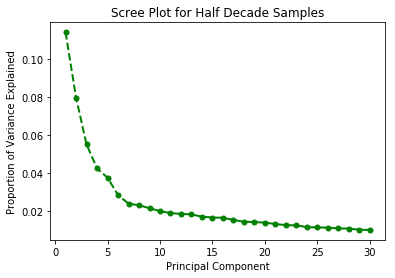

In [11]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(z_scores5) #fit PCA model on training data

explained_variance = pca.explained_variance_ratio_
idxs = list(range(1,n_components+1))
plt.plot(idxs, list(explained_variance), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot for Half Decade Samples")

Text(0.5,1,'Explained Variance for Half Decade Samples')

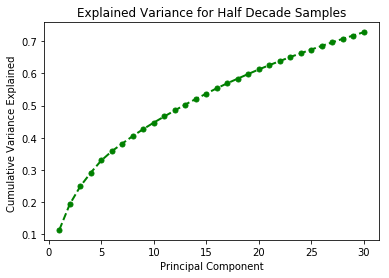

In [12]:
cum_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(idxs, list(cum_variance), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained ")
plt.title("Explained Variance for Half Decade Samples")

In [13]:
print('FINAL TRAINING AND TEST DATAFRAMES FOR DATA DOWNSAMPLED BY HALF DECADE')

train_pca5 = pca.transform(z_scores5) # then apply fit model to both training and test z scores
test_pca5 = pca.transform(z_test_features)

col_names = []
for i in range(1,n_components+1):
    col_names.append('PrinComp' + str(i))

#create the final dataframe (downsampled by half decade) for train data
train_pca5 = pd.DataFrame(data=train_pca5, columns=col_names)  
target5 = target5.reset_index(drop=True)
train5 = pd.concat([target5, train_pca5], axis=1)
display(train5.head())

#create the final dataframe (downsampled by half decade) for test data
test_pca5 = pd.DataFrame(data=test_pca5, columns=col_names)  
test_target = test_target.reset_index(drop=True)
test5 = pd.concat([test_target, test_pca5], axis=1)
display(test5.head())

FINAL TRAINING AND TEST DATAFRAMES FOR DATA DOWNSAMPLED BY HALF DECADE


,Year released,Half decade released,Decade released,PrinComp1,PrinComp2,PrinComp3,PrinComp4,PrinComp5,PrinComp6,PrinComp7,PrinComp8,PrinComp9,PrinComp10,PrinComp11,PrinComp12,PrinComp13,PrinComp14,PrinComp15,PrinComp16,PrinComp17,PrinComp18,PrinComp19,PrinComp20,PrinComp21,PrinComp22,PrinComp23,PrinComp24,PrinComp25,PrinComp26,PrinComp27,PrinComp28,PrinComp29,PrinComp30
0,1977,1975,1970,2.324809,-1.259770,-0.707510,2.416422,1.316997,0.939729,-0.635750,0.754486,1.164614,-0.186542,0.660663,1.092674,-0.834133,-1.604373,0.733504,0.261595,1.609408,0.266703,1.406191,1.450843,0.654636,1.014210,0.337030,-0.244462,-1.500200,1.186637,1.551822,-0.576953,0.287304,-0.607602
1,1970,1970,1970,-2.016259,1.255120,1.517295,0.904589,-0.783632,0.286395,1.518739,1.103711,-0.573908,-0.348314,0.545414,0.855342,0.197696,-2.254827,-0.045438,-0.410198,0.995484,-0.531842,-0.370595,-0.267768,0.662026,-1.084283,-0.235991,-0.353551,0.214580,-0.526399,0.117883,-0.226490,-0.278334,-0.745597
2,1980,1980,1980,1.037886,-0.591882,-1.043462,-1.401989,-3.883700,-1.058006,1.328732,-1.542160,2.684549,-0.298724,-0.981132,-0.808616,-0.155186,0.036041,1.219338,1.254138,-0.923460,0.484530,-0.352798,-1.525365,0.967082,0.328170,-0.463802,0.743927,1.638985,1.127218,1.622613,0.140535,-0.002185,-0.891890
3,1975,1975,1970,-0.587764,1.129836,0.340706,-0.499950,-0.580980,-0.854642,-0.948398,-0.813197,0.327542,-1.073074,-0.275267,-0.046221,-0.303151,0.283440,-0.066695,1.062094,-1.121620,0.549826,0.264580,0.115339,0.648692,-1.362170,0.263875,0.644172,0.026122,0.351079,0.062629,-0.819083,0.491879,0.346468
4,1975,1975,1970,2.842163,1.592109,3.149146,-0.538893,-0.890984,-1.072322,1.545793,-0.434188,-0.672971,0.147472,0.207804,-0.239481,1.292405,-0.487496,-0.450458,0.265649,-0.343757,-0.086345,0.885430,-0.521052,-1.489444,-1.120531,0.077004,-0.099802,-0.670906,-0.102003,0.578060,-0.036144,0.258179,2.263666


,Year released,Half decade released,Decade released,PrinComp1,PrinComp2,PrinComp3,PrinComp4,PrinComp5,PrinComp6,PrinComp7,PrinComp8,PrinComp9,PrinComp10,PrinComp11,PrinComp12,PrinComp13,PrinComp14,PrinComp15,PrinComp16,PrinComp17,PrinComp18,PrinComp19,PrinComp20,PrinComp21,PrinComp22,PrinComp23,PrinComp24,PrinComp25,PrinComp26,PrinComp27,PrinComp28,PrinComp29,PrinComp30
0,2007,2005,2000,-1.875457,1.066680,0.251507,1.110421,-2.044204,1.295341,-0.824032,-1.231301,-0.379401,1.050476,-0.879594,-0.190762,0.044574,0.926735,-0.174249,-0.209183,0.145149,1.120481,-0.429331,-0.285309,-0.501744,-0.645599,-0.071386,-1.218961,-0.104825,-0.636523,0.869247,-0.381882,0.492703,0.022511
1,2003,2000,2000,-3.778955,0.703828,0.895352,-0.893779,-0.731936,0.094773,0.083830,-0.471747,-0.553063,0.903472,-0.853891,0.086411,-0.047052,0.586235,0.213477,0.551211,0.927172,0.344347,-0.589586,-0.269873,-0.532177,0.472497,0.021467,0.164781,-0.119065,0.264415,0.425160,-0.664611,0.062828,-0.287007
2,2005,2005,2000,-1.903817,-0.008928,0.957405,1.541286,0.383235,-0.603894,-0.706125,-0.128671,-0.033778,0.014348,-0.119719,-0.821651,-0.403291,0.763666,-1.238250,-0.095601,0.601264,0.019469,-0.408000,0.131254,-0.846933,1.269647,-0.581836,1.086376,0.120967,0.242663,0.407109,-0.735161,0.468297,0.411123
3,2003,2000,2000,-3.737665,0.758531,1.397926,-0.147110,-1.117747,-0.005269,0.220632,-0.305297,-0.909859,0.567694,-0.369458,-0.113503,0.388839,0.223398,0.293949,0.581736,0.486665,0.253043,-0.445022,-0.140536,-0.431031,0.645874,0.030648,0.334701,0.120999,0.075805,0.291972,-0.612100,0.238147,0.215091
4,2005,2005,2000,-2.012043,1.422571,2.144621,-0.171020,-0.208466,-0.528341,0.604980,-0.295998,-0.551366,0.442896,-0.499489,-0.366420,0.446595,0.267583,0.586163,0.188203,0.110082,-0.323865,-0.715945,-0.060126,-0.268959,0.685391,0.325412,0.594874,-0.073941,0.385499,0.410433,-0.108010,0.858049,0.827429


#### Full decade Downsampling

Text(0.5,1,'Scree Plot for Full Decade Samples')

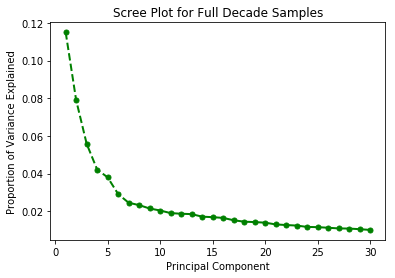

In [14]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(z_scores10) #fit PCA model on training data

explained_variance = pca.explained_variance_ratio_
idxs = list(range(1,n_components+1))
plt.plot(idxs, list(explained_variance), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot for Full Decade Samples")

Text(0.5,1,'Explained Variance for Full Decade Samples')

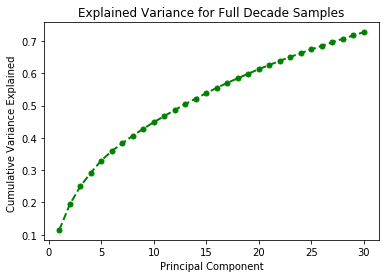

In [15]:
cum_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(idxs, list(cum_variance), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained ")
plt.title("Explained Variance for Full Decade Samples")

In [16]:
print('FINAL TRAINING AND TEST DATAFRAMES FOR DATA DOWNSAMPLED BY FULL DECADE')

train_pca10 = pca.transform(z_scores10) # then apply fit model to both training and test z scores
test_pca10 = pca.transform(z_test_features) #apply the fit derived from the full decade samples to the same test z scores

col_names = []
for i in range(1,n_components+1):
    col_names.append('PrinComp' + str(i))

#create the final dataframe (downsampled by full decade) for train data
train_pca10 = pd.DataFrame(data=train_pca10, columns=col_names)  
target10 = target10.reset_index(drop=True)
train10 = pd.concat([target10, train_pca10], axis=1)
display(train10.head())

#create the final dataframe (downsampled by full decade) for test data
test_pca10 = pd.DataFrame(data=test_pca10, columns=col_names)  
test_target = test_target.reset_index(drop=True)
test10 = pd.concat([test_target, test_pca10], axis=1)
display(test10.head())

FINAL TRAINING AND TEST DATAFRAMES FOR DATA DOWNSAMPLED BY FULL DECADE


,Year released,Half decade released,Decade released,PrinComp1,PrinComp2,PrinComp3,PrinComp4,PrinComp5,PrinComp6,PrinComp7,PrinComp8,PrinComp9,PrinComp10,PrinComp11,PrinComp12,PrinComp13,PrinComp14,PrinComp15,PrinComp16,PrinComp17,PrinComp18,PrinComp19,PrinComp20,PrinComp21,PrinComp22,PrinComp23,PrinComp24,PrinComp25,PrinComp26,PrinComp27,PrinComp28,PrinComp29,PrinComp30
0,1989,1985,1980,-1.554467,-0.654766,1.912710,0.300456,0.489102,1.137898,-0.080199,-0.990821,0.586275,-0.336826,-0.930555,-0.400643,1.750254,-0.196008,-0.355034,-0.174153,0.503431,0.753435,-0.271587,0.346084,-0.028452,-0.405699,-0.833869,-0.724317,1.150692,0.617398,1.761041,0.543799,-0.276036,2.204945
1,1997,1995,1990,-1.892535,0.717543,-0.801855,-0.243590,0.643732,-0.942478,1.393930,0.208918,1.331429,0.880729,2.462723,1.217873,-0.556192,-0.677101,-0.965188,0.166949,0.861569,-0.119987,-1.170832,0.407074,0.044934,-0.048471,-0.304278,-0.822368,-0.491699,-1.003534,-0.401355,0.456371,0.329517,1.286469
2,1984,1980,1980,0.461748,-1.626239,1.130366,0.721512,0.236397,-1.870503,-1.103742,1.708588,0.058245,0.244893,-0.101954,-2.163878,-0.732402,-0.045942,0.700841,0.802696,0.280791,-0.423878,-0.137932,0.580203,-1.498964,-0.578710,-0.078597,0.491996,-1.036829,1.125347,-0.317298,-0.559159,0.438893,0.494162
3,2005,2005,2000,-1.724543,-2.462976,1.257923,0.478680,-1.424211,0.710474,1.004315,0.578255,0.665258,0.121049,-0.527555,0.270516,-1.143935,0.594954,-0.413702,1.480848,-0.206814,0.546576,0.127365,0.824545,-0.213603,-0.697515,-0.140504,0.078425,1.825739,0.237908,0.227149,1.073605,0.712082,-1.237574
4,2004,2000,2000,1.301136,0.248209,-3.501689,0.616617,0.908699,-0.334407,0.327778,-0.841089,1.261870,-0.578034,-0.532933,0.775292,-1.345858,-0.049660,0.242699,-0.117595,0.862542,1.250143,0.082903,-0.805460,0.356142,0.909213,-0.059385,-0.083094,0.800032,0.030501,-0.093453,-0.399440,-0.080297,1.139996


,Year released,Half decade released,Decade released,PrinComp1,PrinComp2,PrinComp3,PrinComp4,PrinComp5,PrinComp6,PrinComp7,PrinComp8,PrinComp9,PrinComp10,PrinComp11,PrinComp12,PrinComp13,PrinComp14,PrinComp15,PrinComp16,PrinComp17,PrinComp18,PrinComp19,PrinComp20,PrinComp21,PrinComp22,PrinComp23,PrinComp24,PrinComp25,PrinComp26,PrinComp27,PrinComp28,PrinComp29,PrinComp30
0,2007,2005,2000,-1.840285,-1.100040,0.304885,1.152615,-1.961799,1.473227,-0.758005,1.163736,-0.260400,0.971199,-0.700813,0.204645,-0.386328,0.768271,-0.513235,-0.393439,0.169193,0.687297,0.577505,0.982355,0.593859,-0.350851,-0.480915,0.324465,1.486731,-0.581751,0.627013,0.044576,-0.041635,-0.763532
1,2003,2000,2000,-3.743261,-0.829914,0.988355,-0.827997,-0.733957,0.133029,0.122444,0.487996,-0.505133,0.812893,-0.851976,0.029224,-0.217651,0.772859,-0.111144,0.510120,1.038322,0.064284,0.355650,0.553726,0.571567,0.040575,0.444564,-0.199403,0.313440,0.300543,0.132682,0.456437,-0.506763,-0.104607
2,2005,2005,2000,-1.894408,0.019008,0.990950,1.563434,0.387695,-0.623924,-0.685215,0.112071,0.010178,-0.010711,0.022693,0.491515,-0.826804,0.126326,-1.399836,-0.348791,0.714756,-0.266928,0.275373,-0.043768,0.978357,-0.098738,1.358533,-0.412550,-0.439087,0.402614,0.232455,0.927957,0.212575,-0.532896
3,2003,2000,2000,-3.683519,-0.872631,1.483825,-0.068592,-1.125446,0.053938,0.279279,0.339377,-0.870053,0.510948,-0.415074,0.408783,0.125667,0.544523,0.070070,0.564425,0.524160,-0.054797,0.340659,0.334267,0.500141,0.094705,0.613582,-0.061296,0.043947,0.142048,0.129910,0.662291,-0.014622,-0.390973
4,2005,2005,2000,-1.928413,-1.499524,2.151090,-0.056538,-0.219359,-0.525814,0.662412,0.306992,-0.521371,0.323506,-0.479783,0.623278,0.053370,0.823704,0.405973,0.147980,0.331163,-0.739046,0.408628,0.014644,0.395168,0.523634,0.508149,-0.289474,-0.145694,0.282838,0.088129,0.529370,0.768663,-0.790671


# Write clean data to CSV

In [17]:
train5.to_csv('train5.csv', index=False) #clean PCA training data, downsampled based on half decades
test5.to_csv('test5.csv', index=False) #clean PCA test data, with half-decade PCA fit applied

train10.to_csv('train10.csv', index=False) #clean PCA training data, downsampled based on full decades
test10.to_csv('test10.csv', index=False) #clean PCA test data, with full-decade PCA fit applied